# Broken Bicycles

I want to find broken bicycles. I am looking for bicycles that:  
1.  During a given day had numerous short trips, from and to same station.  
2.  During a given day did not have many ~~long~~ trips between different stations.

## Let's load the trip data

In [1]:
import pandas as pd
import data_source as ds

df = ds.loadDataset('trip');

df['start_date'] = pd.to_datetime(df['start_date'], dayfirst=False);
df['end_date'] = pd.to_datetime(df['end_date'], dayfirst=False);

data_source.py loaded


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669959 entries, 0 to 669958
Data columns (total 11 columns):
id                    669959 non-null int64
duration              669959 non-null int64
start_date            669959 non-null datetime64[ns]
start_station_name    669959 non-null object
start_station_id      669959 non-null int64
end_date              669959 non-null datetime64[ns]
end_station_name      669959 non-null object
end_station_id        669959 non-null int64
bike_id               669959 non-null int64
subscription_type     669959 non-null object
zip_code              663340 non-null object
dtypes: datetime64[ns](2), int64(5), object(4)
memory usage: 56.2+ MB


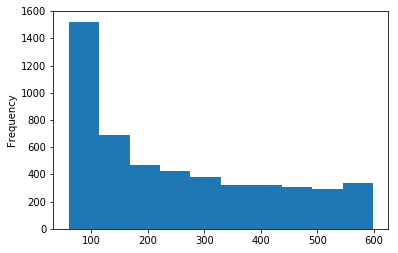

In [17]:
SHORT_TRIP_DURATION_THRESH = 10 * 60;
shortTrips = df[ (df['duration'] < SHORT_TRIP_DURATION_THRESH) & (df['start_station_id'] == df['end_station_id']) ];
shortTrips['duration'].plot('hist')

I will select __3 minutes__ as a short trip thershold.  
Now that we have a dataframe with short trips, let's see how many such trips a single bike had in each day:

In [4]:
SHORT_TRIP_DURATION_THRESH = 3 * 60;
shortTrips = df[ (df['duration'] < SHORT_TRIP_DURATION_THRESH) & (df['start_station_id'] == df['end_station_id']) ];

perBike = shortTrips.groupby(['bike_id', pd.Grouper(key='start_date', freq='D')])\
       .size()\
       .reset_index(name="num");
perBike.rename(columns={'start_date': 'date'}, inplace=True);
# perBike[perBike['num']>2]
perBike.head()

bike_id       date  num
0        9 2014-07-06    1
1       11 2014-08-08    1
2       14 2014-03-20    1
3       14 2015-06-27    1
4       15 2014-04-19    1

### How many short trips per bike per day do we usually have?

In [5]:
perBike['num'].value_counts()

1    2201
2      57
3       5
5       1
Name: num, dtype: int64

I'll keep only those bikes that had 2 or more short trips a day.

In [6]:
SHORT_TRIPS_BROKEN_BIKE_THRESH = 1;
perBike = perBike[perBike['num']>SHORT_TRIPS_BROKEN_BIKE_THRESH];
print('We now have %d (bike, date)s suspected as broken' % (len(perBike)) )
perBike.sort_values('num', ascending=False).head()
# ?perBike.sort_values

We now have 63 (bike, date)s suspected as broken


bike_id       date  num
1575      530 2013-09-18    5
605       332 2013-08-31    3
237       191 2014-10-27    3
1146      446 2013-10-04    3
1745      566 2014-08-11    3

### Now lets look at the bicycles that had no trips between different stations.

To find healthy bicycles,  
We begin with filtering the trips list to only trips between different stations.  
A bicycle can be "healthy" and have a long trip starting and ending in the same station, but i'll ignore those for now.

In [7]:
healthyTrips = df[ df['start_station_id'] != df['end_station_id'] ];
perBikeHealthy = healthyTrips.groupby(['bike_id', pd.Grouper(key='start_date', freq='D')])\
       .size()\
       .reset_index(name="num");
perBikeHealthy.rename(columns={'start_date': 'date'}, inplace=True);
perBikeHealthy.head()

bike_id       date  num
0        9 2013-08-29    1
1        9 2013-08-31    2
2        9 2013-09-07    2
3        9 2013-10-18    1
4        9 2013-10-22    1

Same station, long duration trips:
    

count    1.890600e+04
mean     7.996890e+03
std      2.130863e+04
min      6.010000e+02
25%      1.448000e+03
50%      3.374000e+03
75%      8.048500e+03
max      1.133540e+06
Name: duration, dtype: float64

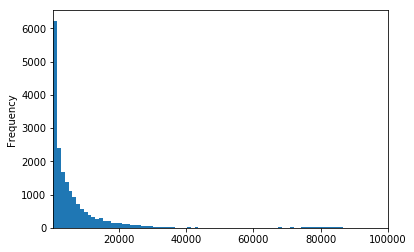

In [8]:
sameStationHealthy = df[ df['start_station_id'] == df['end_station_id'] ];
sameStationHealthy = sameStationHealthy[sameStationHealthy['duration'] > 10*60];
maxDuration = sameStationHealthy['duration'].max();
minDuration = sameStationHealthy['duration'].min();
sameStationHealthy['duration'].plot.hist(bins=1000, xlim=(minDuration, 100000))
sameStationHealthy['duration'].describe()
# ?pd.Series.plot

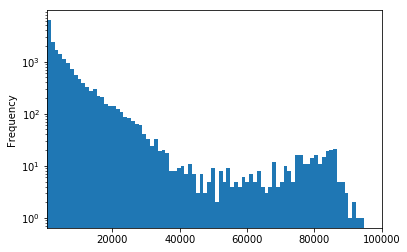

In [9]:
sameStationHealthy['duration'].plot.hist(bins=1000, xlim=(minDuration, 100000), logy=True)

I will just set the threshold to 15 min: any same station trip which took more than 15 min - will be considered a healthy trip.

In [10]:
SAME_STATION_HEALTHY_THRESH = 15 * 60;
sameStationHealthy = sameStationHealthy[sameStationHealthy['duration'] > SAME_STATION_HEALTHY_THRESH];
perBikeHealthy2 = sameStationHealthy.groupby(['bike_id', pd.Grouper(key='start_date', freq='D')])\
       .size()\
       .reset_index(name="num");
perBikeHealthy2.rename(columns={'start_date': 'date'}, inplace=True);
perBikeHealthy2.head()

bike_id       date  num
0        9 2013-08-30    1
1        9 2013-08-31    1
2        9 2013-09-07    1
3        9 2013-09-08    1
4        9 2013-09-14    3

### Combining it all

We will combine healthy trips and healthy trips between same stations.

In [11]:
perBikeHealthy = pd.concat([perBikeHealthy, perBikeHealthy2]);
del perBikeHealthy2

In [12]:
perBike.reset_index(inplace=True);
perBikeHealthy.reset_index(inplace=True);
perBike.set_index(['bike_id', 'date'], inplace=True);
perBikeHealthy.set_index(['bike_id', 'date'], inplace=True);
result = perBike.join(perBikeHealthy, how='left', lsuffix='_bad', rsuffix='_good');

result.head()

index_bad  num_bad  index_good  num_good
bike_id date                                                
16      2014-09-16          7        2       951.0       3.0
26      2013-08-29         21        2      2427.0       2.0
155     2014-07-25        195        2         NaN       NaN
191     2014-10-27        237        3         NaN       NaN
215     2015-04-20        275        2         NaN       NaN

In [13]:
result.fillna(0, inplace=True);
result.drop(['index_good', 'index_bad'], axis=1, inplace=True);


In [14]:
result = result[result['num_good']<4].sort_values(('num_bad'), ascending=False);
result.head()

num_bad  num_good
bike_id date                         
332     2013-08-31        3       1.0
566     2014-08-11        3       2.0
528     2015-01-20        3       3.0
446     2013-10-04        3       1.0
        2013-10-04        3       2.0

This is it...

### Testing

Let's see, for example bike id=191	on: 2014-10-27. It had 3 bad (short, same station trips) and 0 good trips.

In [15]:
import datetime;

df[ (df['bike_id'] == 191)\
   &\
    (df['start_date'].dt.date==datetime.date(year=2014,month=10,day=27))
]

id  duration          start_date  \
609583  517593       108 2014-10-27 17:38:00   
610037  516957        91 2014-10-27 11:19:00   
610053  516939       116 2014-10-27 10:59:00   

                       start_station_name  start_station_id  \
609583  Civic Center BART (7th at Market)                72   
610037  Civic Center BART (7th at Market)                72   
610053  Civic Center BART (7th at Market)                72   

                  end_date                   end_station_name  end_station_id  \
609583 2014-10-27 17:40:00  Civic Center BART (7th at Market)              72   
610037 2014-10-27 11:20:00  Civic Center BART (7th at Market)              72   
610053 2014-10-27 11:01:00  Civic Center BART (7th at Market)              72   

        bike_id subscription_type zip_code  
609583      191        Subscriber    94611  
610037      191        Subscriber    94103  
610053      191        Subscriber    94547

3 short "trips" at "Civic Center BART" station. Last trip made at 17:40. What happens the next day?

In [16]:
df[ (df['bike_id'] == 191)\
   &\
    (df['start_date'].dt.date==datetime.date(year=2014,month=10,day=28))
]

id  duration          start_date         start_station_name  \
608085  519638       354 2014-10-28 17:53:00  Broadway St at Battery St   

        start_station_id            end_date  \
608085                82 2014-10-28 17:59:00   

                                     end_station_name  end_station_id  \
608085  Temporary Transbay Terminal (Howard at Beale)              55   

        bike_id subscription_type zip_code  
608085      191        Subscriber    94710

The next day, it appears in another station. Looks like it was collected for maintainance and dropped in a new location the next day - station "Broadway St at Battery St", where it went out to a healthy trip at 17:53

[dt-accessor](https://pandas.pydata.org/pandas-docs/stable/basics.html#dt-accessor)  
[time-date-components](https://pandas.pydata.org/pandas-docs/stable/timeseries.html#time-date-components)